In [16]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve,least_squares,root

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RollRig as RollRig

from matplotlib.lines import Line2D

me.mechanics_printing()

In [17]:
p = RollRig.base_params(1)

In [18]:
sm = mf.SymbolicModel.from_file('RollRigModel-Fixed.py')
sm.ExtForces = ef.CompositeForce([sm.ExtForces,ef.CustomForce(None)])
sm = sm.subs({p.alpha_r.name:0})

In [19]:
p.c.value = 0.067
p.s.value = 1
p.sigma.value = 0.28
p.m_w.value = 0.22
p.m_f.value = 0.038
p.m_l.value = 0#0.0275
p.alpha_r.value = 0
p.c_d_max.value = 1
p.a_0.value = 2*np.pi
#p.tau.value = 0
p.alpha_r.value = 0
p.w_g.value = 0
p.beta.value = 0

#p.s.value = 0.72
#p.sigma.value = 0
#p.m_f.value = 0
#p.m_l.value = 0


p.Lambda.value = np.deg2rad(10)

In [20]:
nm = mf.NumericModel.from_SymbolicModel(p,sm)

torque_period = 0.1
torque_max = p.beta.value*p.V.value**2

def torque(tup,x,t):
    if t<2:
        return 0
    elif t<torque_period/2+2:
        return torque_max*0.5*(1- np.cos(2*np.pi*(t-2)/torque_period))
    else:
        return torque_max
    
def custom_force(tup,x,t):
    return np.array([[torque(tup,x,t)]])

nm.ExtForces.force_funcs = [ext_f , custom_force]

ext_f = nm.ExtForces.force_funcs[0]

In [21]:
thetadot = sym.Symbol('thetadot')
steadyState = sm.msubs({p.qd[0]:thetadot,p.w_g:0})

eom = steadyState.ExtForces.Q()-steadyState.f+sym.Matrix([p.V**2*p.beta])


eom_func = sym.lambdify((p.GetTuple(),thetadot,p.q),eom)
q = np.deg2rad([0])
d_theta = np.deg2rad(100)
x = eom_func(p.GetNumericTuple([q[0],d_theta],0),d_theta,q)[:,0]
x
#(sm.subs({p.qd[1]:0,p.qd[2]:0}).ExtForces.Q()[0])

array([-0.37446939])

In [34]:
p.V.value = 22.5
p.alpha_c.value = np.deg2rad(0)

#res = fsolve(lambda x,v:eom_func(p.GetNumericTuple([v,x[0],x[1],0,x[2],0],0),x[0],[v,x[1],x[2]])[:,0],np.deg2rad([0,0,0]),args = (0,)) 
res = fsolve(lambda x,v:eom_func(p.GetNumericTuple([v,x[0]],0),x[0],[v])[0,0],np.deg2rad([0]),args = (0,)) 


list(np.round(np.rad2deg(res),2))

In [76]:
end_time = 10

def objectiveDeriv(t,y):
    return nm.deriv(t,y,p.GetNumericTuple(y,t))

# Generate I.C. and run the solver
x = [0]*p.qs*2
yData = solve_ivp(objectiveDeriv,(0,end_time),x,max_step=0.01)

#interpolate to reduce t and y points
int_func = interp1d(yData.t,yData.y)

t = np.linspace(0,end_time,(end_time*100)+1)
yi = int_func(t)

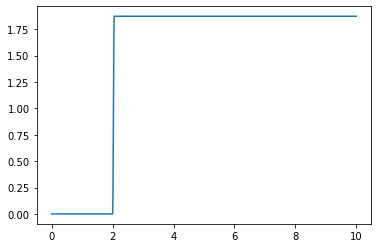

In [77]:
plt.plot(t,[torque((0,),[0],i) for i in t])

IndexError: index 2 is out of bounds for axis 0 with size 2

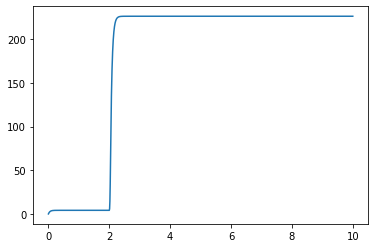

In [79]:
plt.plot(t,np.rad2deg(yi[1,:]))
print(np.mean(np.rad2deg(yi[2,t>4])))

In [62]:
names = ['Roll','Roll Rate','Left FWT Angle','Left FWT Velocity','Right FWT Angle','Right FWT Velocity']
d1 = {n:0 for n in names}
tau = [torque((0,),[0],i) for i in t]
params = {k.name:v for k,v in p.GetSubs(0,None).items()}

#{'t':_t,**d1,**{names[i]:v for i,v in enumerate(yi[:,200])}}


data = [{'t':_t,'torque':tau[i],'Locked':True,**d1,**{names[i]:v for i,v in enumerate(yi[:,i])},**params} for i,_t in enumerate(t)]
df = pd.DataFrame(data)
df

,t,torque,Locked,Roll,Roll Rate,Left FWT Angle,Left FWT Velocity,Right FWT Angle,Right FWT Velocity,c,...,alphadot_1,alpha_2,alphadot_2,C_Dmax,a_0,beta,Lambda,w_g,qtilde0,qtilde1
0,0.00,0.000000,True,0.000000,0.000000,0,0,0,0,0.067,...,0,0,0,1,6.283185,0.0037,0.174533,0,0,0
1,0.01,0.000000,True,0.000075,0.013157,0,0,0,0,0.067,...,0,0,0,1,6.283185,0.0037,0.174533,0,0,0
2,0.02,0.000000,True,0.000263,0.024011,0,0,0,0,0.067,...,0,0,0,1,6.283185,0.0037,0.174533,0,0,0
3,0.03,0.000000,True,0.000548,0.032861,0,0,0,0,0.067,...,0,0,0,1,6.283185,0.0037,0.174533,0,0,0
4,0.04,0.000000,True,0.000914,0.040077,0,0,0,0,0.067,...,0,0,0,1,6.283185,0.0037,0.174533,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,9.96,1.873125,True,31.312475,3.952219,0,0,0,0,0.067,...,0,0,0,1,6.283185,0.0037,0.174533,0,0,0
997,9.97,1.873125,True,31.351998,3.952219,0,0,0,0,0.067,...,0,0,0,1,6.283185,0.0037,0.174533,0,0,0
998,9.98,1.873125,True,31.391520,3.952219,0,0,0,0,0.067,...,0,0,0,1,6.283185,0.0037,0.174533,0,0,0
999,9.99,1.873125,True,31.431042,3.952219,0,0,0,0,0.067,...,0,0,0,1,6.283185,0.0037,0.174533,0,0,0


In [53]:
p.GetSubs(0,None)

In [60]:
p.GetSubs(0,None).items()

dict_items([(c, 0.067), (s, 1), (sigma, 0.28), (m_w, 0.22), (m_f, 0.038), (m_l, 0), (rho, 1.225), (V, 22.5), (g, 9.81), (alpha_r, 0), (alpha_c, 0.0), (alpha_0, 0), (alphadot_0, 0), (alpha_1, 0), (alphadot_1, 0), (alpha_2, 0), (alphadot_2, 0), (C_Dmax, 1), (a_0, 6.283185307179586), (beta, 0.0037), (Lambda, 0.17453292519943295), (w_g, 0), (qtilde0, 0), (qtilde1, 0)])

In [67]:
a = [{'a':1,'b':2},{'a':3,'b':4}]
{**a[0]}

{'a': 1, 'b': 2}

In [69]:
yi.T[0]

array([0., 0.])

In [72]:
def GenRunData(model,p,ic,end_time,xNames=None,additional_cols = {},sample_freq=100):
    
    if xNames==None:
        xNames = [f'x{i}' for i in range(p.qs*2)]
    
    # create objective function and solve
    def objectiveDeriv(t,y):
        return nm.deriv(t,y,p.GetNumericTuple(y,t))
    yData = solve_ivp(objectiveDeriv,(0,end_time),ic,max_step=1/sample_freq)
    
    t = np.linspace(0,end_time,(end_time*100)+1)
   
    #interpolate to reduce t and y points
    int_func = interp1d(yData.t,yData.y)  
    yi = int_func(t)
    
    #generate list
    tau = [torque((0,),[0],i) for i in t]
    q_data = [{names[i]:v for i,v in enumerate(row)}for row in yi.T]    
    params = {k.name:v for k,v in p.GetSubs(0,None).items()}


    data = [{'t':_t,'torque':tau[i],'Locked':True,**q_data[i],**params,**additional_cols} for i,_t in enumerate(t)]
    return data
    

In [75]:
names = ['Roll','Roll Rate','Left FWT Angle','Left FWT Velocity','Right FWT Angle','Right FWT Velocity']
data = GenRunData(nm,p,[0,0],10,names[:2],{n:0 for n in names[2:]},100)
df = pd.DataFrame(data)
df

,t,torque,Locked,Roll,Roll Rate,c,s,sigma,m_w,m_f,...,a_0,beta,Lambda,w_g,qtilde0,qtilde1,Left FWT Angle,Left FWT Velocity,Right FWT Angle,Right FWT Velocity
0,0.00,0.000000,True,0.000000,0.000000,0.067,1,0.28,0.22,0.038,...,6.283185,0.0037,0.174533,0,0,0,0,0,0,0
1,0.01,0.000000,True,0.000075,0.013157,0.067,1,0.28,0.22,0.038,...,6.283185,0.0037,0.174533,0,0,0,0,0,0,0
2,0.02,0.000000,True,0.000263,0.024011,0.067,1,0.28,0.22,0.038,...,6.283185,0.0037,0.174533,0,0,0,0,0,0,0
3,0.03,0.000000,True,0.000548,0.032861,0.067,1,0.28,0.22,0.038,...,6.283185,0.0037,0.174533,0,0,0,0,0,0,0
4,0.04,0.000000,True,0.000914,0.040077,0.067,1,0.28,0.22,0.038,...,6.283185,0.0037,0.174533,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,9.96,1.873125,True,31.312475,3.952219,0.067,1,0.28,0.22,0.038,...,6.283185,0.0037,0.174533,0,0,0,0,0,0,0
997,9.97,1.873125,True,31.351998,3.952219,0.067,1,0.28,0.22,0.038,...,6.283185,0.0037,0.174533,0,0,0,0,0,0,0
998,9.98,1.873125,True,31.391520,3.952219,0.067,1,0.28,0.22,0.038,...,6.283185,0.0037,0.174533,0,0,0,0,0,0,0
999,9.99,1.873125,True,31.431042,3.952219,0.067,1,0.28,0.22,0.038,...,6.283185,0.0037,0.174533,0,0,0,0,0,0,0
